<a href="https://colab.research.google.com/github/SangMin316/DL-with-PyTorch/blob/main/DL_with_PyTorch5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import library

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

load data

In [2]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving catanddog.zip to catanddog.zip


In [3]:
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

preprocessing

In [4]:
data_path = 'catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224), # augmentation, randomly crop and resize
                    transforms.RandomHorizontalFlip(), 
                    transforms.ToTensor(),
                ])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
# data_loder가 데이터를 불러올 경로와 transform을 정의,

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8, # data load할 때 subprocess 몇개할지 설정
    shuffle = True
)

print(len(train_dataset))

385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


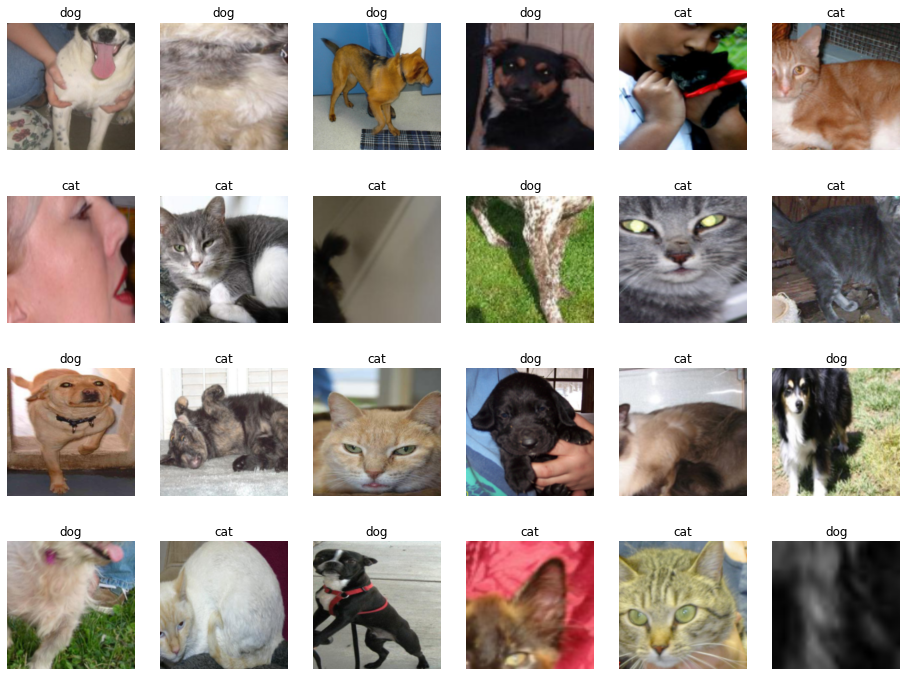

In [5]:
import numpy as np
samples, labels = iter(train_loader).next()
# iter()는 절달된 데이터의 반복자를 꺼내 반환, next()는 그 반복자가 다음에 출력해야할 요소를 반환
# 즉 iter()로 반복자를 구하고 그 반복자를 next()에 전달하여 자례대로 꺼내는 것
# train_loder에서 데이터를 하나씩 써내오겠다

classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))

for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) #(1,2,0)는 orginal(x,y,z) -> (y,z,x)로
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

사전훈련된 model down

In [6]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

model freezing

In [7]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # BP할때 parameter 변화를 계산할 필요가 없음.
            
set_parameter_requires_grad(resnet18)

fully connecter layer 연결하기

In [8]:
resnet18.fc = nn.Linear(512, 2)

참고, 모델 파라미터 값들 확인하기

In [9]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0211,  0.0433, -0.0026,  ..., -0.0285, -0.0398,  0.0182],
        [ 0.0324,  0.0303, -0.0208,  ...,  0.0268,  0.0074, -0.0067]])
fc.bias tensor([-0.0348, -0.0252])


모델의 객체를 생성하고 loss fn 정의

In [10]:
model = models.resnet18(pretrained = True)

# ResNet18 freezing
for param in model.parameters():
    param.requires_grad = False

# add fc, learning
model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

model 학습을 위한 함수 생성

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs): # 13번 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device) 
            labels = labels.to(device) 
            
            model.to(device)
            optimizer.zero_grad() # 기울기 0으로 설정
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)  # 평균 오차
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch))) 
        # 모델 재사용을 위해, 모델 저장
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

마지막 fc는 학습이 되도록 설정

In [12]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
print(params_to_update)            
optimizer = optim.Adam(params_to_update) # 학습결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias
[Parameter containing:
tensor([[ 0.0211,  0.0433, -0.0026,  ..., -0.0285, -0.0398,  0.0182],
        [ 0.0324,  0.0303, -0.0208,  ...,  0.0268,  0.0074, -0.0067]],
       requires_grad=True), Parameter containing:
tensor([-0.0348, -0.0252], requires_grad=True)]


train model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 0.5155 Acc: 0.7610

Epoch 1/12
----------
Loss: 0.3820 Acc: 0.8571

Epoch 2/12
----------
Loss: 0.3875 Acc: 0.8312

Epoch 3/12
----------
Loss: 0.3159 Acc: 0.8675

Epoch 4/12
----------
Loss: 0.2667 Acc: 0.8961

Epoch 5/12
----------
Loss: 0.2533 Acc: 0.8961

Epoch 6/12
----------
Loss: 0.1943 Acc: 0.9351

Epoch 7/12
----------
Loss: 0.2331 Acc: 0.9013

Epoch 8/12
----------
Loss: 0.2014 Acc: 0.9273

Epoch 9/12
----------
Loss: 0.2171 Acc: 0.9065

Epoch 10/12
----------
Loss: 0.1731 Acc: 0.9558

Epoch 11/12
----------
Loss: 0.1612 Acc: 0.9429

Epoch 12/12
----------
Loss: 0.2581 Acc: 0.8753

Training complete in 0m 44s
Best Acc: 0.955844


이제 test dataset에서 성능을 봅시다.

preprocessing

In [15]:
test_path = 'catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


evaluation을 위한 함수 생성

In [17]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum() #preds와 labels가 일치하는 지 검사
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [18]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.8469

Loading model catanddog/01.pth
Acc: 0.9592

Loading model catanddog/02.pth
Acc: 0.9184

Loading model catanddog/03.pth
Acc: 0.9388

Loading model catanddog/04.pth
Acc: 0.9490

Loading model catanddog/05.pth
Acc: 0.9286

Loading model catanddog/06.pth
Acc: 0.9490

Loading model catanddog/07.pth
Acc: 0.9388

Loading model catanddog/08.pth
Acc: 0.9388

Loading model catanddog/09.pth
Acc: 0.9286

Loading model catanddog/10.pth
Acc: 0.9388

Loading model catanddog/11.pth
Acc: 0.9388

Loading model catanddog/12.pth
Acc: 0.9592

Validation complete in 0m 9s
Best Acc: 0.959184


plot the result

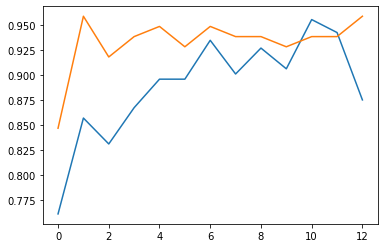

In [19]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

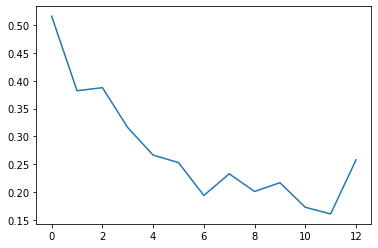

In [20]:
plt.plot(train_loss_hist)
plt.show()

단순히 정확도와 오차 정보를 확인하는 것에 머무르지 않고, 실제 데이터를 잘 
예측하는지 살펴보겠습니다.

먼저 예측된 이미지를 출력하기 위한 전처리 함수를 생성합니다.

In [22]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    # tensor.clone()은 tensor 복제(메모리에 새롭게 할당), detach()는 기울기에 영향을 주지 않겠다는 의미
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  #입력값이 주어진 범위로 제한, 넘어가는 놈은 경계값으로 return
    return image  

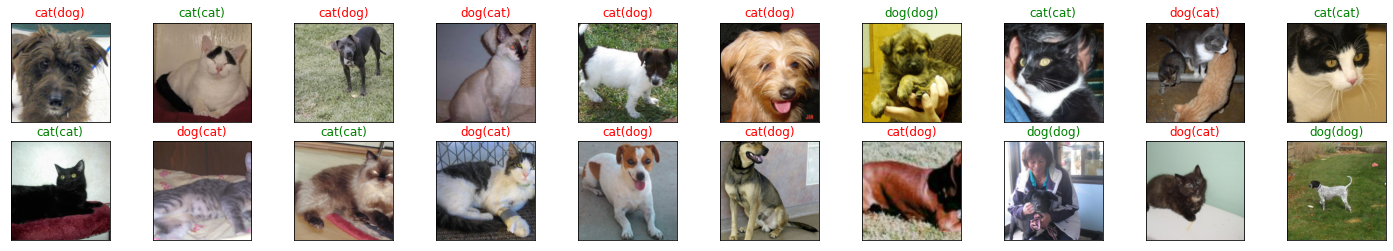

<Figure size 432x288 with 0 Axes>

In [23]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  

images,labels=dataiter.next()  
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
    #classes[[preds[idx].item()]는 preds[idx].item()] 값이 0이면 고양이, 1이면 개로 출력
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)